In [134]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [135]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [136]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

mkdir: cannot create directory 'TRAIN': File exists
mkdir: cannot create directory 'TEST': File exists
mkdir: cannot create directory 'VAL': File exists
mkdir: cannot create directory 'TRAIN/YES': File exists
mkdir: cannot create directory 'TRAIN/NO': File exists
mkdir: cannot create directory 'TEST/YES': File exists
mkdir: cannot create directory 'TEST/NO': File exists
mkdir: cannot create directory 'VAL/YES': File exists
mkdir: cannot create directory 'VAL/NO': File exists
.
|-- TEST
|   |-- NO
|   `-- YES
|-- TEST_CROP
|   |-- NO
|   `-- YES
|-- TRAIN
|   |-- NO
|   `-- YES
|-- TRAIN_CROP
|   |-- NO
|   `-- YES
|-- VAL
|   |-- NO
|   `-- YES
`-- VAL_CROP
    |-- NO
    `-- YES

18 directories


In [137]:
import shutil
IMG_PATH = "/kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [138]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    labels = {}
    for i, path in enumerate(tqdm(sorted(os.listdir(dir_path)))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    resized_img = cv2.resize(img, img_size)
                    X.append(resized_img)
                    y.append(i)
    return np.array(X), np.array(y), labels

In [139]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)

In [140]:
X_train, y_train, labels_train = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, labels_test = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, labels_val = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


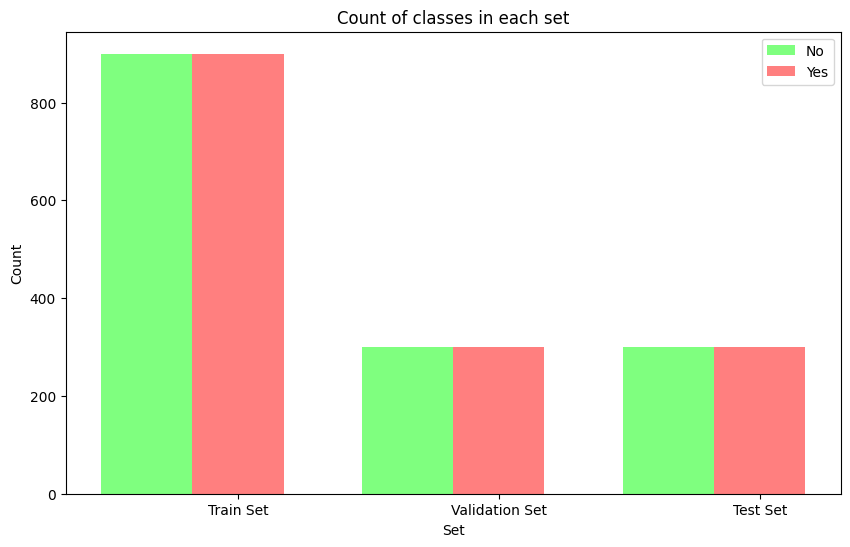

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate counts for each class in each set
train_counts = [np.sum(y_train == i) for i in range(num_classes)]
val_counts = [np.sum(y_val == i) for i in range(num_classes)]
test_counts = [np.sum(y_test == i) for i in range(num_classes)]

# Define the sets and class labels
sets = ['Train Set', 'Validation Set', 'Test Set']
classes = ['No', 'Yes']

# Define colors for each class
colors = [(0, 1, 0, 0.5), (1, 0, 0, 0.5)] # Green for 'No', Red for 'Yes'

# Plotting
plt.figure(figsize=(10, 6))

# Plot bars for each class in each set
bar_width = 0.35
index = np.arange(len(sets))

for i in range(num_classes):
    plt.bar(index + i * bar_width, [train_counts[i], val_counts[i], test_counts[i]], bar_width, label=classes[i], color=colors[i])

plt.xlabel('Set')
plt.ylabel('Count')
plt.title('Count of classes in each set')
plt.xticks(index + bar_width, sets)
plt.legend()
plt.show()

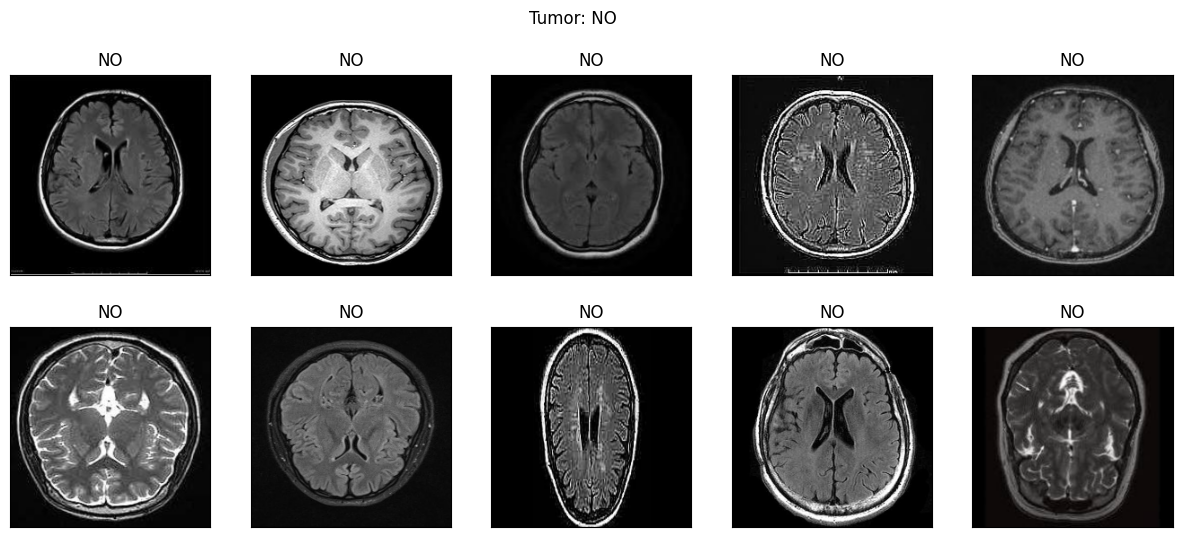

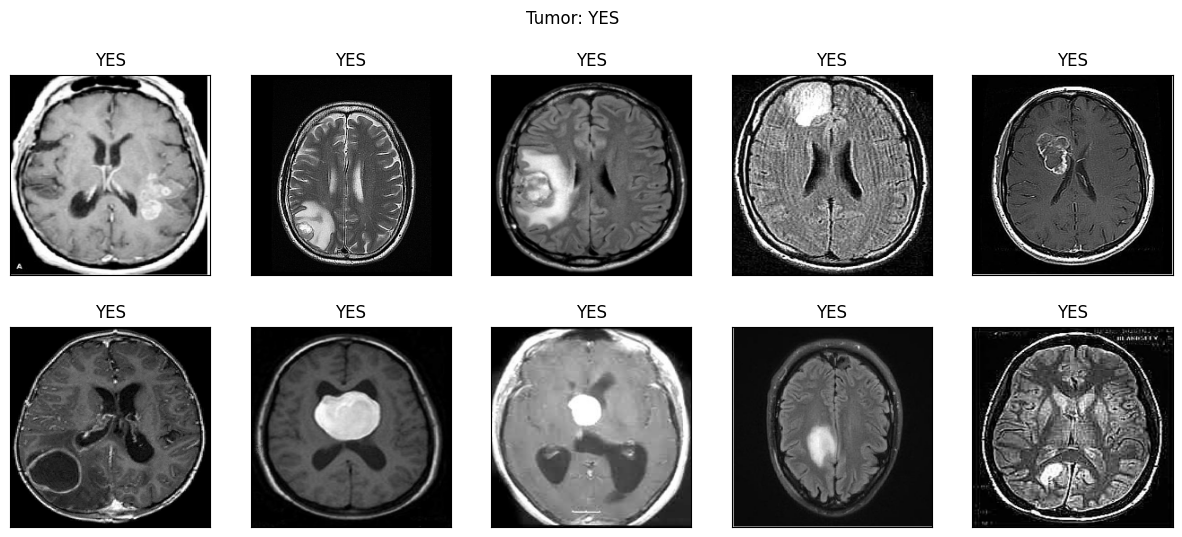

In [142]:
def plot_samples(X, y, labels_dict, n=50):
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n / j)

        plt.figure(figsize=(15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            plt.title(labels_dict[index])  
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

plot_samples(X_train, y_train, labels_train, 10)

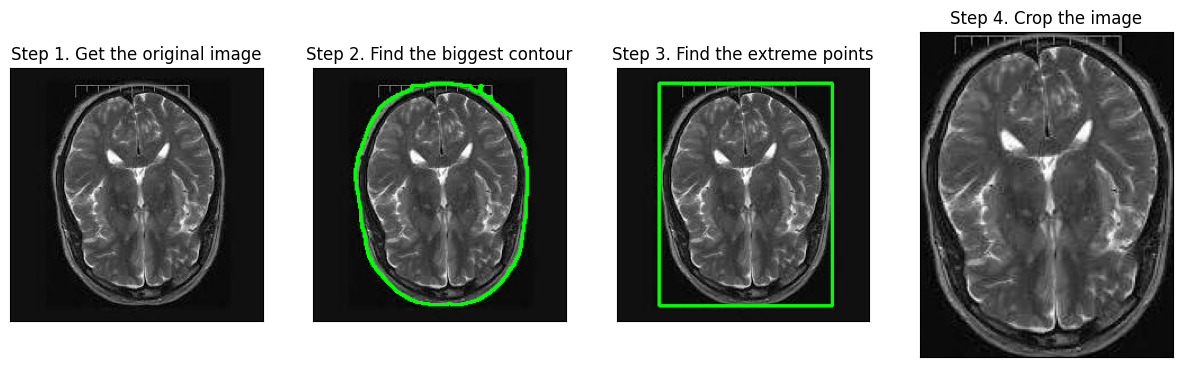

In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_brain_contour(image, plot=False):
    # Step 1: Get the original image
    img = image.copy()
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Step 2: Find the biggest contour
    img_cnt = img.copy()
    cv2.drawContours(img_cnt, [largest_contour], 0, (0, 255, 0), 2)
    
    # Step 3: Find the extreme points
    img_pnt = img.copy()
    x, y, w, h = cv2.boundingRect(largest_contour)
    cv2.rectangle(img_pnt, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Step 4: Crop the image
    new_img = img[y:y+h, x:x+w]
    
    if plot:
        plt.figure(figsize=(15,6))
        plt.subplot(141)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 1. Get the original image')
        
        plt.subplot(142)
        plt.imshow(img_cnt)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 2. Find the biggest contour')
        
        plt.subplot(143)
        plt.imshow(img_pnt)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 3. Find the extreme points')
        
        plt.subplot(144)
        plt.imshow(new_img)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 4. Crop the image')

        plt.show()
    
    return new_img

# Example usage
image_path = '/kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection/no/no10.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)
cropped_image = crop_brain_contour(image, plot=True)


In [144]:
def crop_imgs(set_name, img_size=(224, 224)):
    cropped_images = []
    for img in set_name:
        cropped_img = crop_brain_contour(img)
        resized_img = cv2.resize(cropped_img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
        cropped_images.append(resized_img)
    return np.array(cropped_images)


In [145]:
def save_new_images(x_set, y_set, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    for i, (img, imclass) in enumerate(zip(x_set, y_set)):
        class_folder = os.path.join(folder_name, 'YES' if imclass == 1 else 'NO')
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        cv2.imwrite(os.path.join(class_folder, f'{i}.jpg'), img)

In [146]:
# Crop images
X_train_crop = crop_imgs(X_train)
X_val_crop = crop_imgs(X_val)
X_test_crop = crop_imgs(X_test)

# Save cropped images
save_new_images(X_train_crop, y_train, 'TRAIN_CROP')
save_new_images(X_val_crop, y_val, 'VAL_CROP')
save_new_images(X_test_crop, y_test, 'TEST_CROP')

In [147]:
# Resizing the images
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
        set_new.append(img)
    return np.array(set_new)

IMG_SIZE = (224, 224)
X_train_prep = preprocess_imgs(X_train_crop, IMG_SIZE)
X_test_prep = preprocess_imgs(X_test_crop, IMG_SIZE)
X_val_prep = preprocess_imgs(X_val_crop, IMG_SIZE)

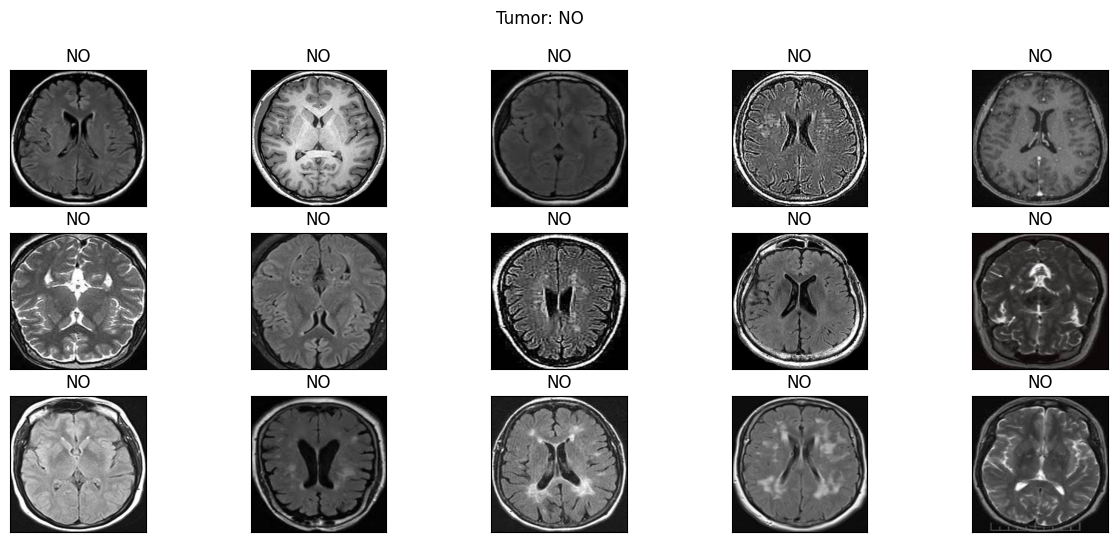

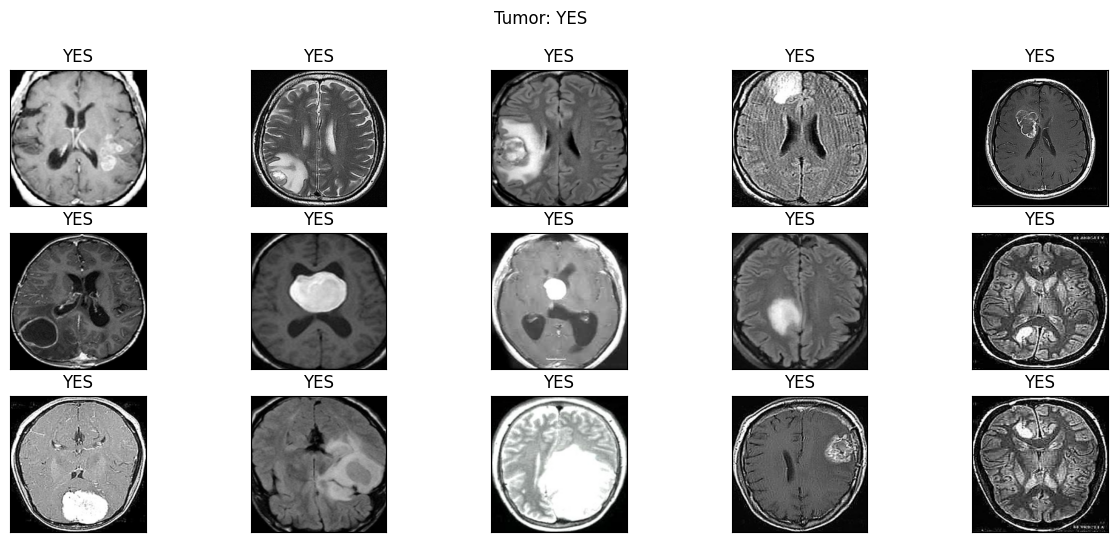

In [148]:
# Plot samples
def plot_samples(X, y, labels_dict, n=50):
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n / j)

        plt.figure(figsize=(15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            plt.title(labels_dict[index])  
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

plot_samples(X_train_prep, y_train, labels_train, 15)

In [149]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
IMG_SIZE = (224, 224)

# Load pre-trained DenseNet169 model
base_Neural_Net = DenseNet169(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet', include_top=False)

# Create a Sequential model
model = Sequential()

# Add the pre-trained DenseNet169 model
model.add(base_Neural_Net)

# Flatten the output of DenseNet
model.add(Flatten())

# Batch normalization
model.add(BatchNormalization())

# Dense layer with more units
model.add(Dense(512, activation='relu'))

# Dropout layer for regularization
model.add(Dropout(0.5))

# Batch normalization
model.add(BatchNormalization())

# Output layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Unfreeze last layers of the base model
for layer in base_Neural_Net.layers[:-10]:
    layer.trainable = True

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'AUC'])

In [150]:
from tensorflow.keras.applications.densenet import preprocess_input
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42

# Define data generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Define Early Stopping callback
es = EarlyStopping(
    monitor='val_accuracy',  
    mode='max',
    patience=6
)

# Define data generators
train_generator = train_datagen.flow_from_directory(
    'TRAIN_CROP/',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=42
)

validation_generator = test_datagen.flow_from_directory(
    'VAL_CROP/',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    'TEST_CROP/',
    target_size=IMG_SIZE,
    batch_size=16,  # Adjust batch size as needed
    class_mode='binary',
    seed=42
)


Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [154]:
# Train the model with augmented data
history = model.fit(
    train_datagen.flow_from_directory(
        'TRAIN_CROP/',
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='binary',
        seed=42
    ),
    steps_per_epoch=50,
    epochs=10,  # Increase the number of epochs
    validation_data=validation_generator,  # Use the same validation generator
    validation_steps=25,
    callbacks=[es]
)

Found 1800 images belonging to 2 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - AUC: 0.9520 - accuracy: 0.8982 - loss: 0.2837 - val_AUC: 0.7895 - val_accuracy: 0.6950 - val_loss: 1.5175
Epoch 2/10
 7/50 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - AUC: 0.9760 - accuracy: 0.9124 - loss: 0.2133

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - AUC: 0.9699 - accuracy: 0.9148 - loss: 0.2244 - val_AUC: 0.7856 - val_accuracy: 0.6000 - val_loss: 1.6912
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - AUC: 0.9720 - accuracy: 0.9167 - loss: 0.2164 - val_AUC: 0.9666 - val_accuracy: 0.6300 - val_loss: 0.9454
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - AUC: 0.9811 - accuracy: 0.9158 - loss: 0.1773 - val_AUC: 0.8767 - val_accuracy: 0.5900 - val_loss: 1.4558
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 447ms/step - AUC: 0.9575 - accuracy: 0.9037 - loss: 0.2630 - val_AUC: 0.7181 - val_accuracy: 0.6175 - val_loss: 6.7830
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - AUC: 0.9787 - accuracy: 0.9330 - loss: 0.1862 - val_AUC: 0.8426 - val_accuracy: 0.6450 - val_loss: 3.3815


In [155]:
# Evaluate the model on the training data
train_loss, train_accuracy, train_auc = model.evaluate(train_generator)
print('Train Accuracy:', train_accuracy)

# Evaluate the model on the validation data
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator)
print('Validation Accuracy:', val_accuracy)

# Evaluate the model on the test data
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)
print('Test Accuracy:', test_accuracy)


57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 423ms/step - AUC: 0.8405 - accuracy: 0.6896 - loss: 2.9155
Train Accuracy: 0.8307549357414246
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.8185 - accuracy: 0.6384 - loss: 3.2451
Validation Accuracy: 0.797261118888855
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - AUC: 0.8532 - accuracy: 0.6666 - loss: 3.5899
Test Accuracy: 0.8289166688919067
